Import librairies and packages

In [5]:
from tdmclient import ClientAsync, aw

import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import Vision.CamCalib as calib
import Vision.EnvTracker as tracker
import time
import cv2

sys.path.insert(0, os.path.join(os.getcwd(), 'LocalNav/sensors'))
from local_occupancy import thymio_coords

sys.path.insert(0, os.path.join(os.getcwd(), 'plot'))
from plot import plot

sys.path.insert(0, os.path.join(os.getcwd(), 'LocalNav'))
sys.path.insert(0, os.path.join(os.getcwd(), 'GlobalNav'))
from LocalNav import localNav
#from GlobalNav import GlobalNav

CancelledError: 

Initialize components & objects

In [10]:
USE_THYMIO = False

if USE_THYMIO:
    client = ClientAsync()
    node = await client.wait_for_node()
    await node.lock()
    #Create a Client Object:
    client = ClientAsync()

    client.process_waiting_messages()

# Parameters
MAP_SIZE = (100, 100)  # In cm

# Position
abs_pos = [[20, 20, 0]] # absolute x,y,theta coordinates of the robot
# Goal Position
goal_position = [[80, 80]]

# Initialize camCalib object to retrieve camera parameters
cam_calib = calib.CamCalib(None, (16,9))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()
quit = False
run = True
wait_for_map = True
map_created = False

# Initialize the environment tracker object to create global map and track thymio
env_tracker = tracker.EnvTracker((100,100), cam_mat, dist_coefs)

map_global = np.zeros((100,100))


Main loop (run thymio)

Pixels per grid cell: 11.75 x 8.66
[75.83487221 63.66980273]


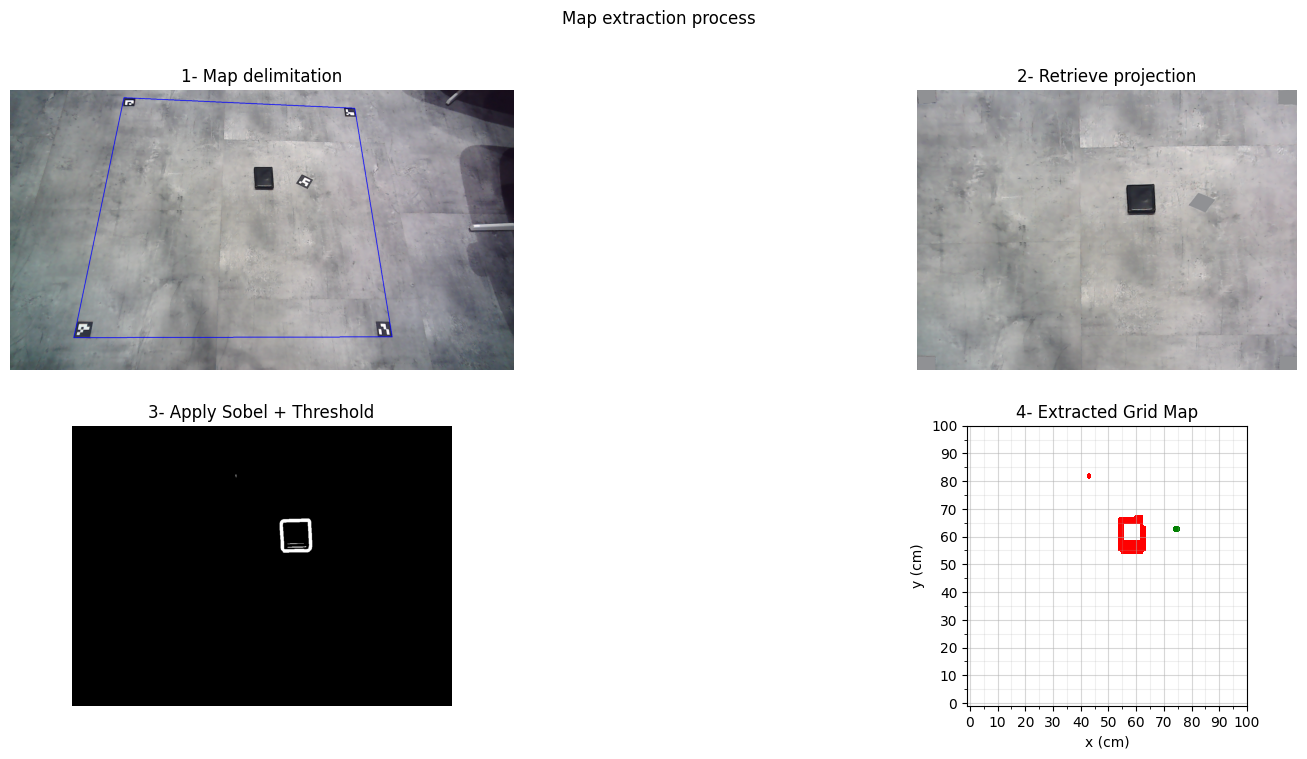

In [11]:
# Open camera feed & initialize map
cv2.destroyAllWindows()
cv2.namedWindow("Thymio Tracking", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Thymio Tracking", 1920, 1080)
cam_feed = cv2.VideoCapture(0)
cam_feed.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam_feed.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
if not cam_feed.isOpened():
    print("ERROR :: Could not open camera video feed!")
while (wait_for_map):
    ret, frame = cam_feed.read()
    # Undistord image
    frame_corrected, roi = cam_calib.undistord(frame, cam_mat, dist_coefs)
    x,y,w,h = roi
    frame_corrected = frame_corrected[y:y+h, x:x+w, :]
    marker_detected, img_markers = env_tracker.detectMarkers(frame_corrected)
    map_detected, img_markers = env_tracker.detectMap(img_markers)
    goal_detected, img_markers = env_tracker.detectGoal(img_markers)
    if map_detected:
        img_markers = env_tracker.extractMapCornerPose(img_markers)
        img_markers = cv2.putText(img_markers, "MAP DETECTED", (img_markers.shape[1] - 300, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0], 2)
    if goal_detected:
        goal_pose, _ = env_tracker.goalPose(frame_corrected)
        img_markers = cv2.putText(img_markers, f'GOAL: {np.round(goal_pose, 1)}', (img_markers.shape[1] - 300, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0], 2)
        text_goal = f'GOAL: {np.round(goal_pose, 1)}'
    cv2.imshow("Thymio Tracking",img_markers)
    key = cv2.waitKey(1)
    if key == ord('q'):
        quit = True
        wait_for_map = False
    elif key == ord(' '):
        # Create map
        if map_detected and goal_detected:
            map_global = env_tracker.createMap(frame_corrected, bl_marker=0)
            map_created = True
            wait_for_map = False


# Map is ready, run the thymio
plt.show()
quit = True
while run and not quit:
    
    aw(node.lock())
    await node.wait_for_variables({"prox.horizontal"})
    prox_horizontal = list(node.v.prox.horizontal)

    map_global = localNav(abs_pos, goal_position, prox_horizontal, map_global)

    # Plot
    plot(abs_pos, thymio_coords, goal_position, map_global, abs_pos[0][2])
    time.sleep(1)
    clear_output(wait=True)  # Clear the previous plot

cv2.destroyAllWindows()
cam_feed.release()